In [1]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
from GPy.kern import Kern
from GPy import Param, Model
from deepRBF import deepRBF
#from MFRBF import MFRBF

In [2]:
from MFRBF import *

In [3]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def compute_nll(y, mf, vf):
    y = y.reshape((y.shape[0],))
    ll = -0.5 * np.log(2 * np.pi * vf) - 0.5 * (y - mf)**2 / vf
    nll = -ll
    return np.mean(nll)

In [4]:
def predict_eff(CovMtx, Y):
    K_ee = CovMtx[1:,1:]
    K_e = CovMtx[0,1:]
    K_inv = np.linalg.inv(K_ee+0.0001*np.eye(K_ee.shape[0]))
    pred_mu = np.matmul(np.matmul(K_e, K_inv), Y)
    pred_v = CovMtx[0,0] - np.matmul(np.matmul(K_e, K_inv), np.matrix.transpose(K_e))
    return pred_mu, np.sqrt(pred_v)


In [27]:
def f_low(x):
    return np.sin(8*np.pi*x)

def f_high(x):
    return (x-np.sqrt(2)) * (f_low(x))**2

num_cheap = 30
num_expensive = 15

np.random.seed(59)
X1 = np.random.rand(num_cheap)[:,None]
#X2 = np.linspace(0,1,num_expensive)[:,None]
X2 = np.random.rand(num_expensive)[:,None]
Yc = f_high(X1) + 0.1 * np.random.normal(0,1,num_cheap)[:,None]

Ye = f_high(X2) + 0.001 * np.random.normal(0,1,num_expensive)[:,None]

In [28]:
K1 = GPy.kern.RBF(input_dim = 1, variance = 1, lengthscale = 0.1)
m1 = GPy.models.GPRegression(X1, Yc, K1, noise_var = 0.0001)
m1.optimize(messages=True)
m1.optimize_restarts(num_restarts = 10)
#m1.plot()

Optimization restart 1/10, f = 7.3149792503539075
Optimization restart 2/10, f = 15.661449316320478
Optimization restart 3/10, f = 15.661449316364049
Optimization restart 4/10, f = 15.661449316358523
Optimization restart 5/10, f = 15.661449325360445
Optimization restart 6/10, f = 15.66144931633089
Optimization restart 7/10, f = 15.661449316311089
Optimization restart 8/10, f = 15.6614493163119
Optimization restart 9/10, f = 15.661449316358793
Optimization restart 10/10, f = 15.661449316311579


In [29]:
mu, v = m1.predict(X2, full_cov = True)

deepKern = MFRBF(input_dim=1, variance = 0.8, lengthscale = 0.2, mu = mu, v=v)
kRBF = GPy.kern.RBF(input_dim = 1)

effKern = kRBF * deepKern

In [30]:
m2 = GPy.models.GPRegression(X2, Ye, effKern)
m2.optimize()

In [31]:
m2.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -17.285504347710372
Optimization restart 2/10, f = -17.28556395300572
Optimization restart 3/10, f = -17.285563837372273
Optimization restart 4/10, f = -17.28556354320932
Optimization restart 5/10, f = -17.28556379192876
Optimization restart 6/10, f = -17.285563937271696
Optimization restart 7/10, f = -17.28556376992331
Optimization restart 8/10, f = -17.28556355768243
Optimization restart 9/10, f = -17.285564010809377
Optimization restart 10/10, f = -17.285564126198658


In [32]:
print(m2)


Name : GP regression
Objective : -17.285564126198658
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  mul.rbf.variance         |     0.15899720217825938  |      +ve      |        
  mul.rbf.lengthscale      |       3.873343770168442  |      +ve      |        
  mul.MFRBF.variance       |       1.913714751167662  |               |        
  mul.MFRBF.lengtscale     |       1.756175105543778  |               |        
  Gaussian_noise.variance  |  1.3853790815269179e-11  |      +ve      |        


In [33]:
print(m2.kern.rbf.variance[0])
print(m2.kern.rbf.lengthscale[0])
print(m2.kern.MFRBF.variance[0])
print(m2.kern.MFRBF.lengthscale[0])

0.15899720217825938
3.873343770168442
1.913714751167662
1.756175105543778


In [34]:
#s1=0.8817598540664018 
#l1=1.0049914242449915
#s2=0.41618880973211025
#l2=0.740372462046252 

s1 = m2.kern.rbf.variance[0]
l1 = m2.kern.rbf.lengthscale[0]
s2 = m2.kern.MFRBF.variance[0]
l2 = m2.kern.MFRBF.lengthscale[0]

X_test = np.linspace(0,1,99)[:,None]
Y_test=[]
Y_test_up=[]
Y_test_down=[]

for xx in X_test:
    Xnew = np.vstack((xx,X2))
    mu1, v1 = m1.predict(Xnew, full_cov = True)
    kernMF = MFRBF(input_dim=1,variance = s2, lengthscale = l2, mu = mu1, v=v1)
    kernRBF = GPy.kern.RBF(input_dim = 1, variance = s1, lengthscale = l1)
    M1 = kernMF.K(Xnew)
    M2 = kernRBF.K(Xnew)
    GG = np.multiply(M1, M2)
    
    pred_mu, pred_v = predict_eff(GG, Ye)
    
    Y_test.append(pred_mu)
    Y_test_up.append(pred_mu+1.96*pred_v)
    Y_test_down.append(pred_mu-1.96*pred_v)

In [35]:
X_plot = np.linspace(0,1,200)[:,None]
f_c=f_low(X_plot)
f_e=f_high(X_plot)

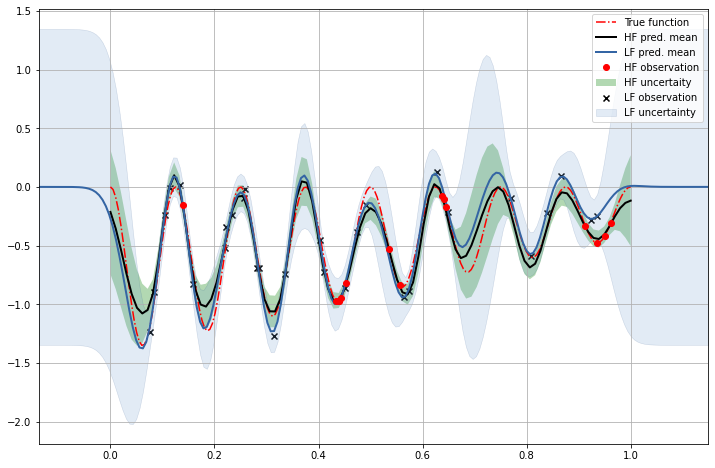

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(X_plot,f_e,'r-.')
#plt.plot(X_plot,f_c,'b.')
plt.plot(X_test,Y_test,'k-',linewidth=2)
plt.fill_between(np.array(X_test).flatten(),np.array(Y_test_up).flatten(),np.array(Y_test_down).flatten(),facecolor='g',alpha=0.3)
m1.plot(ax=ax,legend=False)
plt.plot(X2,Ye,'ro')
plt.grid()
ax.legend(('True function','HF pred. mean','LF pred. mean','HF observation','HF uncertaity','LF observation','LF uncertainty'))
#plt.title('Low')
plt.show()

In [52]:
fig.savefig('noise_reduce.pdf', bbox_inches='tight')

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fcb64ed2ad0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fcb64e35e90>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fcb64eca6d0>]}

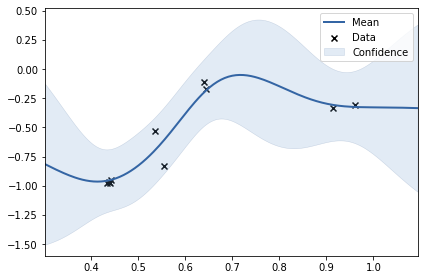

In [15]:
d_rbf = deepRBF(input_dim=X2.shape[1])
m3 = GPy.models.GPRegression(X2, Ye,d_rbf)
m3.optimize()
m3.plot()